# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Петряйкин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

** Общая формула градиентного спуска **  
$$w_i^{m + 1} = w_i^m - \lambda \frac{\partial }{{\partial {w_i}}}\left( {L + \frac{1}{C}\sum\limits_{i = 1}^D {\left| {{w_i}} \right|} } \right)$$

** Основная часть **  
$\begin{align}
  & \frac{\partial L}{\partial {{w}_{i}}}=\frac{1}{N}\frac{\partial \left( \sum\limits_{k=1}^{N}{\log \left( 1+\exp \left( -{{y}^{k}}g({{x}^{k}}) \right) \right)} \right)}{\partial {{w}_{i}}}=-\frac{1}{N}\sum\limits_{k=1}^{N}{\frac{{{y}^{k}}x_{i}^{k}\exp \left( -{{y}^{k}}g({{x}^{k}}) \right)}{1+\exp \left( -{{y}^{k}}g({{x}^{k}}) \right)}}=-\frac{1}{N}\sum\limits_{k=1}^{N}{\frac{{{y}^{k}}x_{i}^{k}}{1+\exp \left( {{y}^{k}}g({{x}^{k}}) \right)}} \\ 
 & g({{x}^{k}})=\sum\limits_{i=1}^{D}{{{w}_{i}}x_{i}^{k}} \\
 & \frac{\partial g({{x}^{k}})}{\partial {{w}_{i}}}=x_{i}^{k},\text{ }x_{0}^{k}=1 \\ 
\end{align}$  
(числитель и знаменатель домножили на $\exp \left( {{y}^{k}}g({{x}^{k}}) \right)$ 

В нашем случае - SGD по одному объекту:  
$$\frac{\partial L}{\partial {{w}_{i}}}=-{\frac{{{y}^{k}}x_{i}^{k}}{1+\exp \left( {{y}^{k}}g({{x}^{k}}) \right)}}$$
Для всех k от 1 до N в некотором перемешанном порядке (эпоха)

** Производная L1-регуляризации **  
Будем использовать SGD-Clipping.  
$$w_{i}^{m+0.5}=w_{i}^{m}-\lambda \frac{\partial L}{\partial {{w}_{i}}}$$  
Если $w_{i}^{m+0.5}>0$:  
$$w_{i}^{m+1}=\max \left( 0,w_{i}^{k+0.5}-\frac{\lambda }{C} \right)$$  
Если $w_{i}^{m+0.5}<0$:  
$$w_{i}^{m+1}=\min \left( 0,w_{i}^{k+0.5}+\frac{\lambda }{C} \right)$$  

Sign (где производная - просто знак модуля) тоже реализуем, т.к. он быстрее

** Об эпохах **  
Эпоха - это прохождение по всем объектам выборки. Но если мы пройдем по всем объектам (обновляя на каждом градиент => не будет даже векторизации), это займет очень долгое время, делая саму идею SGD бесполезной.  
Поэтому введем параметр count_for_epoch - количество объектов, на которых обновляется SGD в течение эпохи. При count_for_epoch = 1 это будет "классическим" стохастическим градиентным спуском

## Имплементация (5 баллов)

In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.1, max_epoch=10, epsilon=None, count_for_epoch=20, SGDcorrection='clipping',
                 need_debug=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.epsilon = epsilon
        self.count_for_epoch = count_for_epoch
        
        self.need_debug = need_debug
        
        if SGDcorrection == 'clipping':
            self.SGDcorrection = np.vectorize(self.__SGDClipping, excluded=['self', 'alpha'])
        else:
            self.SGDcorrection = self.__SGDSign
            
    def __SGDSign(self, w, alpha):
        return w - np.sign(w)*alpha/self.C
        
    def __SGDClipping(self, w, alpha):
        if w == 0:
            return 0
        if w > 0:
            return max(0, w-alpha/self.C)
        else:
            return min(0, w+alpha/self.C)
    
    # Добавляет столбец x0 = 1
    def __concatenate_ones(self, X):
        return np.concatenate((np.ones(X.shape[0]).reshape(-1,1), X), axis = 1)
    
    def __error(self, X, y):
        return -1.0/X.shape[0] * np.sum(np.log(sigmoid(y * np.sum(self.W*X, axis=1))))
        
    # Отличие fit от partial_fit - только в начальной инициализации self.W
    def __fit_core(self, X, y):
        N = X.shape[0]
        Xcorr = self.__concatenate_ones(X)
        
        y_uniq = np.unique(y)
        if (len(y_uniq) > 2):
            raise ValueError("Logistic regression can fit only two classes!")
        ycorr = np.ones(len(y))
        #print y_uniq.shape
        #print ycorr.shape
        #print (y == y_uniq[0]).shape
        ycorr[y == y_uniq[0]] = -1 #Сделали классы +1 и -1
        #ycorr = y*2-1 # Заменим 0 на -1
        
        epoch_alpha = self.alpha
        self.errors = np.zeros((self.max_epoch,))
        self.deltaw = np.zeros((self.max_epoch,))
        
        # Рандом - дорогая операция. Поэтому сгенерируем сразу на все эпохи
        random_indices = np.random.choice(N, (self.max_epoch, self.count_for_epoch))
        for epoch in xrange(self.max_epoch):
            W_prev = np.copy(self.W)
            
            # Градиент пересчитывается после каждого объекта => цикл (не векторизация)
            # В течение эпохи обновляется градиент на count_for_epoch случайных объектах
            for i in random_indices[epoch]:
                dL = -1.0 * ycorr[i] * Xcorr[i]
                #print np.exp(ycorr[i]*np.sum(self.W*Xcorr[i]))
                dL /= 1 + np.exp(ycorr[i] * np.sum(self.W*Xcorr[i]))
                self.W -= epoch_alpha * dL
                self.SGDcorrection(self.W, alpha=epoch_alpha)
                #print i
            
            # Проверка схождения
            self.deltaw[epoch] = np.square(self.W - W_prev).sum()
            #print self.deltaw[epoch]
            if not (self.epsilon is None):
                #print np.square(self.W - W_prev).sum()
                if self.deltaw[epoch] < self.epsilon*self.epsilon:
                    break
            epoch_alpha = self.alpha / (epoch+1)
            if self.need_debug == True:
                self.errors[epoch] = self.__error(Xcorr, ycorr)
    
    # y - должен принимать значения +1 или -1
    def fit(self, X, y):
        '''
        Обучение модели
        '''
        # Начальное приближение - единицы, на 1 больше - учитываем w0
        self.W = np.ones(X.shape[1]+1)
        self.__fit_core(X, y)
        print "fit ended"
        return self
    
    # y - должен принимать значения +1 или -1
    def partial_fit(self, X, y):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        self.__fit_core(X, y)
        return self
        
    # Метки классов - +1 или -1
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        Xcorr = self.__concatenate_ones(X)
        negative = (Xcorr * self.W).sum(axis=1) < 0
        y_hat = np.ones(X.shape[0])
        y_hat[negative] = -1
        return y_hat
    
    # Будем возвращать вероятность класса +1
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        Xcorr = self.__concatenate_ones(X)
        y_hat_proba = sigmoid(-(Xcorr * self.W).sum(axis=1))
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

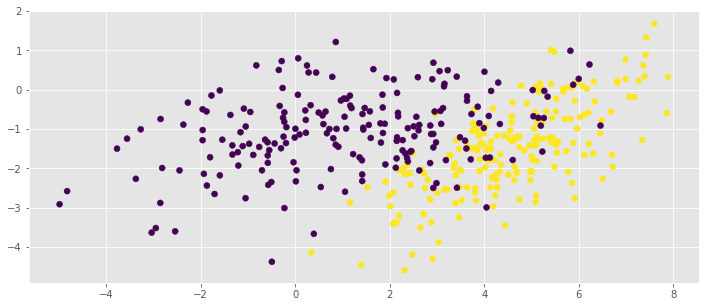

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

fit ended
W: [-3.41393867  0.75022351 -0.7346379 ]


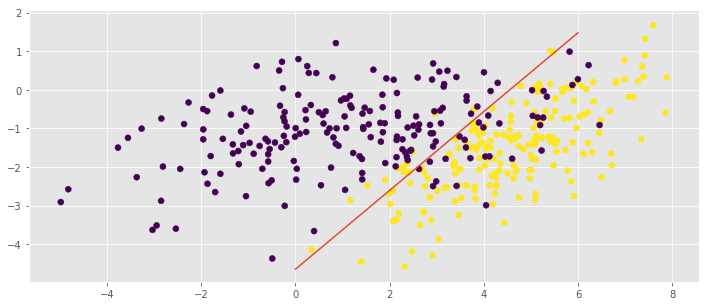

In [5]:
my_classif = MySGDClassifier(alpha=0.5, max_epoch=100)
my_classif.fit(X, y)

print "W:", my_classif.W
# w0+w1*x+w2*y = 0 => y = -(w0+w1*x)/w2
plt.plot([0, 6], [(-my_classif.W[0]/my_classif.W[2]), (-my_classif.W[0] - my_classif.W[1]*6)/my_classif.W[2]])
plt.scatter(X[:,0], X[:,1], c=y)

#print "Errors", my_classif.errors
#print "Summ squares delta w", my_classif.deltaw

#print my_classif.predict(X)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [6]:
from sklearn.datasets import make_classification

In [7]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)
print X.shape

(100000L, 10L)


Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [8]:
# Профайлинг

from line_profiler import LineProfiler
lp = LineProfiler()
model = MySGDClassifier(alpha=0.5, max_epoch=10000, count_for_epoch=1, SGDcorrection='sign', need_debug=False)
model.W = np.ones(X.shape[1]+1)
lp_wrapper = lp(model._MySGDClassifier__fit_core)
lp_wrapper(X, y)
lp.print_stats()

Timer unit: 3.10483e-07 s

Total time: 0.36513 s
File: <ipython-input-3-9877d1243860>
Function: __fit_core at line 51

Line #      Hits         Time  Per Hit   % Time  Line Contents
    51                                               def __fit_core(self, X, y):
    52         1           15     15.0      0.0          N = X.shape[0]
    53         1        26039  26039.0      2.2          Xcorr = self.__concatenate_ones(X)
    54                                                   
    55         1        12391  12391.0      1.1          y_uniq = np.unique(y)
    56         1           14     14.0      0.0          if (len(y_uniq) > 2):
    57                                                       raise ValueError("Logistic regression can fit only two classes!")
    58         1          347    347.0      0.0          ycorr = np.ones(len(y))
    59                                                   #print y_uniq.shape
    60                                                   #print ycorr.sh

fit ended
0.2 [  1.95365175e+00   2.06399889e-02   3.42947477e-02   4.49784081e-04
  -2.36808661e+00  -9.18311266e-01   2.24624838e+00   3.68494222e-02
  -1.23527477e+00   1.85723697e-02  -4.80730631e-02]
fit ended
0.4 [ 2.75059634 -0.02700617  0.02417554 -0.02480521 -2.62033411 -1.21028825
  2.6171514   0.08668536 -1.66598432 -0.03325631 -0.04145144]
fit ended
0.6 [ 2.80622775  0.01827078  0.05289965 -0.07110765 -2.62557951 -1.38765639
  2.47671013  0.07532611 -1.98401681 -0.01553179 -0.02611994]
fit ended
0.8 [  3.44471089e+00   2.61475833e-03   4.35640321e-02  -5.58297300e-03
  -2.76108124e+00  -1.66507834e+00   2.78541411e+00  -4.20476159e-02
  -2.13271840e+00  -2.56177807e-02   3.72088245e-02]
fit ended
1.0 [ 3.89762762 -0.08240751  0.01911101 -0.14276013 -3.04322191 -1.76785823
  3.07155888 -0.01308583 -2.56959021 -0.01260413  0.00566986]
fit ended
1.2 [ 4.25855842  0.03941209 -0.01537662 -0.05074124 -2.87596254 -2.0432529
  3.13126782  0.08569191 -2.59022522  0.0863531  -0.01145

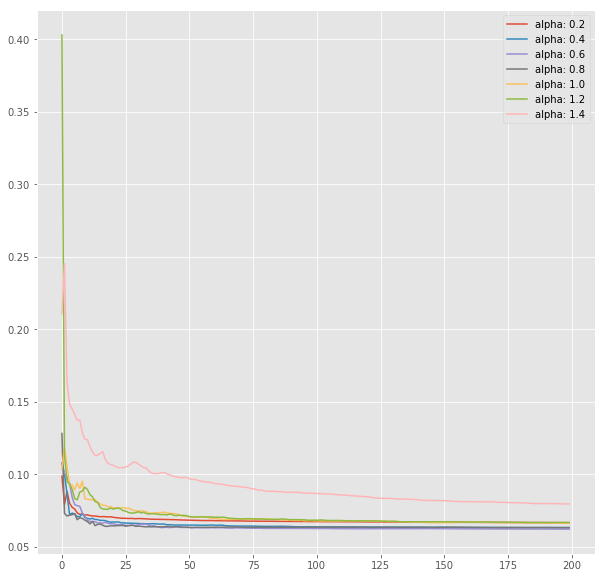

In [9]:
## Your Code Here
plt.figure(figsize=(10,10))
for alpha in np.arange(0.2, 1.6, 0.2):
    #need_debug=True требует времени, SGDcorrection='sign' (кроме того, у нас нет корреляций по условию)
    model = MySGDClassifier(alpha=alpha, max_epoch=500, count_for_epoch=100, SGDcorrection='sign', need_debug=True)
    model.fit(X, y)
    plt.plot(model.errors[0:200], label='alpha: ' + str(alpha)) # 200 первых, чтобы лучше было видно колебания
    print alpha, model.W
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

fit ended
[ 2.66797636 -0.0730657   0.02515351 -0.05144261 -2.62560914 -1.31148519
  2.46073963  0.01865295 -1.88404058  0.0189278  -0.04764837]
fit ended
[  2.87029835e+00   1.55117177e-02  -2.67931407e-03  -4.62719962e-02
  -2.61753945e+00  -1.27843228e+00   2.64185287e+00   6.92944798e-02
  -1.74969496e+00   2.62898659e-02   1.53210800e-02]
fit ended
[  2.74330017e+00  -1.65485703e-03   3.51207523e-02  -2.78390662e-02
  -2.52988618e+00  -1.30739302e+00   2.51745532e+00   6.63629365e-02
  -1.78315199e+00  -5.88510131e-02  -1.58564540e-02]
fit ended
[ 2.71964673  0.02550383 -0.01649391 -0.06464325 -2.5678879  -1.24247317
  2.61453039  0.01706181 -1.69024023  0.03891109  0.00701578]
fit ended
[ 2.68208996  0.01240855  0.03694501 -0.06664739 -2.40327168 -1.44227686
  2.30446388  0.0118368  -1.94404225  0.02945379  0.00523688]
fit ended
[  2.70401669e+00  -1.31739760e-02   5.33755838e-02  -8.38781177e-02
  -2.76713181e+00  -1.10775083e+00   2.72139910e+00   2.62069324e-02
  -1.61222134e+

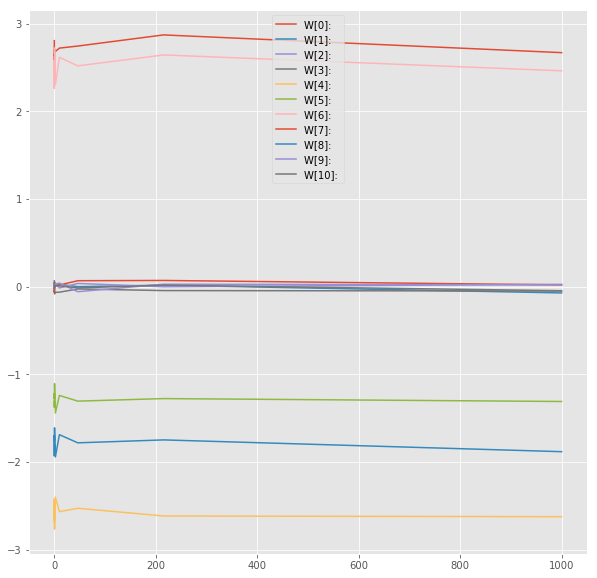

In [10]:
## Your Code Here
coefficients = list()
for c_value in np.logspace(3, -3, 10):
    model = MySGDClassifier(alpha=0.5, max_epoch=500, count_for_epoch=100, C=c_value)
    model.fit(X, y)
    coefficients.append(model.W)
    print model.W

coefficients = np.array(coefficients)
plt.figure(figsize=(10,10))
for i in xrange(coefficients.shape[1]):
    plt.plot(np.logspace(3, -3, 10), coefficients[:,i], label='W[{}]: '.format(i))
plt.legend()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [11]:
# Загрузка данных целиком
df_list = []
for chunk in range(1,5):
    filepath = './trainingData/trainingData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

# Загрузка одной части данных
#filepath = './trainingData/trainingData_tabular_chunk1.csv'
#df_data = pd.read_csv(filepath, sep=',')

In [12]:
df_data.shape

(2000000, 45)

In [13]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [14]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [15]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.5047995

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [16]:
## Youd Code Here
unique_card_opponent = df_data['opponent_hero_card_id'].nunique()
unique_card_player = df_data['player_hero_card_id'].nunique()
print "unique_card_opponent = {}".format(unique_card_opponent)
print "unique_card_player = {}".format(unique_card_player)

unique_card_opponent = 9
unique_card_player = 9


In [17]:
df_dummies = pd.get_dummies(df_data, columns=['opponent_hero_card_id', 'player_hero_card_id'])
df_dummies.shape
df_dummies.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


In [18]:
X_train = np.array(df_dummies.iloc[:, 1:].values) #убираем решение
print X_train[0:3]
print X_train.shape
y_train = np.array(df_dummies.iloc[:, :1].values).ravel()
print y_train[0:3]

[[14  0  0  5  0  0 10 10 11  0  2  1  0  0 17  1  0 10  0 12  0  5  5  1
   2  4  6  8  5 21 20 20 23  4  0  1  5  0 20 22 17  0  0  0  0  0  0  1
   0  0  0  0  0  0  0  0  0  1  0]
 [ 7  0  0 22  0  0  6  6 19  0  8  1  0  0 29  0  0  7  0 18  0  7  5  1
   2  4  2  4  5 10 16 16 17  3  2  2  7  0 17 26 20  0  0  0  0  0  1  0
   0  0  0  0  0  0  0  1  0  0  0]
 [ 5  3  0 29  0  0  4  1 22  0  4  2  1  0 30  0  0  6  5 22  0  5  0  2
   8  5  8  8  0  0  0  0  0  5  0  0  5  2 26 28 27  0  0  0  0  1  0  0
   0  0  0  0  0  0  1  0  0  0  0]]
(2000000L, 59L)
[1 1 1]


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [44]:
## Youd Code Here
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# count_for_epoch=1 - настоящий SGD
headstone_model = MySGDClassifier(alpha=10.0, max_epoch=100, count_for_epoch=20000, SGDcorrection='sign', need_debug=False)
pipeline = Pipeline([('scaler', StandardScaler()),('model', headstone_model)])

In [45]:
pipeline.fit(X_train, y_train)

E:\C_folders\Users\Fen\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in exp


fit ended


RuntimeError: maximum recursion depth exceeded in cmp

Странно, почему возникает исключение, хотя fit корректно заканчивает работу

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [46]:
## Youd Code Here
df_list_test = []
for chunk in range(5,8):
    filepath = './testData/testData_tabular_chunk%d.csv' % chunk
    df_list_test.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list_test)
df_dummies_test = pd.get_dummies(df_data_test, columns=['opponent.hero_card_id', 'player.hero_card_id'])

X_test = np.array(df_dummies_test.iloc[:, 2:].values) #Т.к. еще id
y_check = pd.read_csv('./testData/testLabels.txt', header=None).values

print X_test.shape
print y_check.shape

(1250000L, 59L)
(1250000L, 1L)


In [47]:
from sklearn.metrics import roc_auc_score
y_test = headstone_model.predict(X_test)
score = roc_auc_score(y_check, y_test)
print score

0.666034693903
